[*********************100%%**********************]  1 of 1 completed
c:\Users\Кирилл\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━

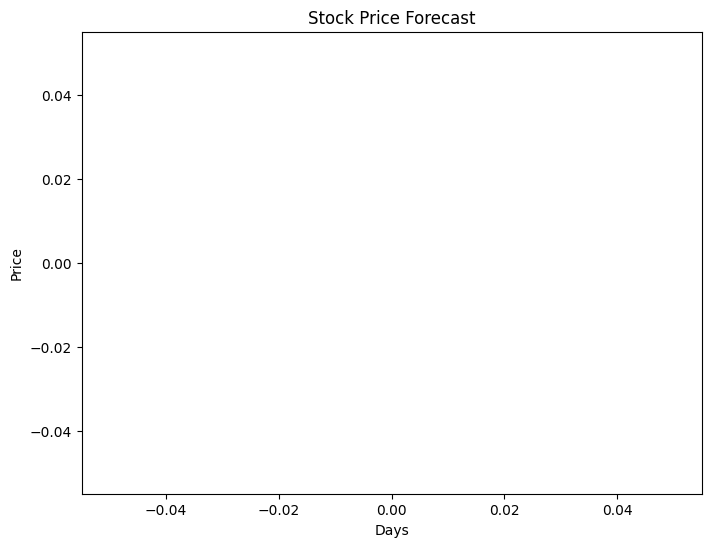

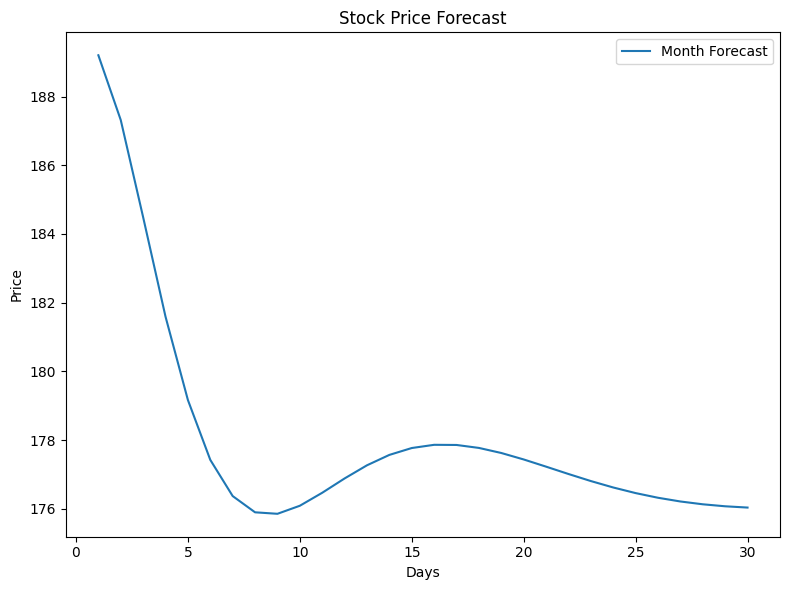

In [1]:
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import threading
import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import LambdaCallback
import PySimpleGUI as sg
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# Функция для получения данных акции
def get_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    data.dropna(inplace=True)
    return data

# Функция для создания набора данных
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step)])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Функция для создания модели LSTM
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(100))
    model.add(Dropout(0.2))
    model.add(Dense(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Функция для отображения графика на интерфейсе
def draw_figure(canvas, figure):
    figure_canvas_agg = FigureCanvasTkAgg(figure, canvas)
    figure_canvas_agg.draw()
    figure_canvas_agg.get_tk_widget().pack(side='top', fill='both', expand=1)
    return figure_canvas_agg

def train_and_predict(window, data_source, data, ticker, start_date, end_date, canvas_key):
    if data_source == 'WEB':
        data = get_stock_data(ticker, start_date, end_date)
    else:
        data = pd.read_csv(data)

    if not data.empty:
        # Предобработка данных
        data = data[['Close', 'Open', 'High', 'Low', 'Volume']]
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(data)

        training_data_len = int(np.ceil(len(scaled_data) * .8))

        train_data = scaled_data[0:int(training_data_len), :]
        X_train, y_train = create_dataset(train_data, time_step=60)

        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

        # Создание и обучение модели
        model = build_lstm_model((X_train.shape[1], X_train.shape[2]))

        # Колбэк для вывода информации об эпохах
        epoch_callback = LambdaCallback(
            on_epoch_end=lambda epoch, logs: window.write_event_value(f'-EPOCH-{canvas_key}-', f'Epoch {epoch+1}/50\n - loss: {logs["loss"]:.4f}')
        )

        model.fit(X_train, y_train, batch_size=64, epochs=50, verbose=0, callbacks=[epoch_callback])

        # Создание тестового набора данных
        test_data = scaled_data[training_data_len - 60:, :]
        X_test, y_test = create_dataset(test_data, time_step=60)
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

        # Прогнозирование и оценка модели
        predictions = model.predict(X_test)
        predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]
        y_test = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]

        mse = mean_squared_error(y_test, predictions)
        window.write_event_value(f'-MSE-{canvas_key}-', f'{mse:.4f}')

        # Прогноз на месяц
        last_60_days = scaled_data[-60:]
        future_predictions = []
        for _ in range(30):
            last_60_days_reshaped = np.reshape(last_60_days, (1, last_60_days.shape[0], last_60_days.shape[1]))
            next_pred = model.predict(last_60_days_reshaped)
            future_predictions.append(next_pred[0, 0])
            next_pred_full = np.zeros((last_60_days.shape[1]))
            next_pred_full[0] = next_pred[0, 0]
            last_60_days = np.append(last_60_days[1:], [next_pred_full], axis=0)

        future_predictions = scaler.inverse_transform(np.concatenate((np.array(future_predictions).reshape(-1, 1), np.zeros((30, scaled_data.shape[1]-1))), axis=1))[:,0]
        month_forecast = future_predictions

        month_str = '\n'.join([f'Day {i+1}: {price:.2f}' for i, price in enumerate(month_forecast)])
        window.write_event_value(f'-MONTH-{canvas_key}-', month_str)

        # Визуализация прогнозов
        plt.figure(figsize=(8, 6))
        plt.plot(range(1, 31), month_forecast, label='Month Forecast')
        plt.xlabel('Days')
        plt.ylabel('Price')
        plt.title('Stock Price Forecast')
        plt.legend()
        plt.tight_layout()
        figure = plt.gcf()
        window.write_event_value(f'-FIGURE-{canvas_key}-', figure)

# Определение макета интерфейса
layout = [
    [
        sg.TabGroup([
            [
                sg.Tab('Web Data', [
                    [sg.Text('Введите тикер акции:')], 
                    [sg.InputText('AAPL', key='-TICKER-WEB-')],
                    [sg.Text('Выберите начальную дату:'), sg.Input(key='-START-WEB-', enable_events=True, size=(10, 1)), sg.CalendarButton('Выбрать дату', target='-START-WEB-', format='%Y-%m-%d')],
                    [sg.Text('Выберите конечную дату:'), sg.Input(key='-END-WEB-', enable_events=True, size=(10, 1)), sg.CalendarButton('Выбрать дату', target='-END-WEB-', format='%Y-%m-%d')],
                    [sg.Button('Прогнозировать', key='-PREDICT-WEB-'), sg.Text('', key='-STATUS-WEB-', size=(15, 1))],
                    [sg.Text('Среднеквадратичная ошибка (MSE):'), sg.Text('', key='-MSE-WEB-')],
                    [sg.Text('Прогноз на следующий месяц:')],
                    [sg.Multiline('', size=(30, 15), key='-MONTH-WEB-')],
                    [sg.Text('Процесс обучения:')],
                    [sg.Multiline('', size=(30, 15), key='-EPOCHS-WEB-')]
                ]),
                sg.Tab('CSV Data', [
                    [sg.Text('Выберите CSV файл:')],
                    [sg.Input(key='-CSV-', enable_events=True), sg.FileBrowse()],
                    [sg.Button('Прогнозировать из файла', key='-PREDICT-CSV-'), sg.Text('', key='-STATUS-CSV-', size=(15, 1))],
                    [sg.Text('')],
                    [sg.Text('')],
                    [sg.Text('Среднеквадратичная ошибка (MSE):'), sg.Text('', key='-MSE-CSV-')],
                    [sg.Text('Прогноз на следующий месяц:')],
                    [sg.Multiline('', size=(30, 15), key='-MONTH-CSV-')],
                    [sg.Text('Процесс обучения:')],
                    [sg.Multiline('', size=(30, 15), key='-EPOCHS-CSV-')]
                ])
            ]
        ]),
        sg.Canvas(size=(700, 480), key='-GRAPH-')  # Один canvas для графика
    ]
]

window = sg.Window('Stock Price Predictor', layout, finalize=True)

# Создаем пустой график при запуске
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot([], [])
ax.set_title('Stock Price Forecast')
ax.set_xlabel('Days')
ax.set_ylabel('Price')
canvas_elem = draw_figure(window['-GRAPH-'].TKCanvas, fig)
canvas_width, canvas_height = canvas_elem.get_width_height()

while True:
    event, values = window.read()
    if event == sg.WINDOW_CLOSED:
        break
    if event == '-PREDICT-WEB-':
        ticker = values['-TICKER-WEB-']
        start_date = values['-START-WEB-']
        end_date = values['-END-WEB-']
        threading.Thread(target=train_and_predict, args=(window, 'WEB', None, ticker, start_date, end_date, 'WEB'), daemon=True).start()
    if event == '-PREDICT-CSV-':
        csv_filepath = values['-CSV-']
        threading.Thread(target=train_and_predict, args=(window, 'CSV', csv_filepath, None, None, None, 'CSV'), daemon=True).start()
    if event.startswith('-EPOCH-'):
        canvas_key = event.split('-')[2]
        current_text = values[f'-EPOCHS-{canvas_key}-']
        window[f'-EPOCHS-{canvas_key}-'].update(current_text + '\n' + values[event] + '\n')
    if event.startswith('-MSE-'):
        canvas_key = event.split('-')[2]
        window[f'-MSE-{canvas_key}-'].update(values[event])
    if event.startswith('-MONTH-'):
        canvas_key = event.split('-')[2]
        window[f'-MONTH-{canvas_key}-'].update(values[event])
    if event.startswith('-FIGURE-'):
        figure = values[event]
        for child in window['-GRAPH-'].TKCanvas.winfo_children():
            child.destroy()
        canvas_elem = draw_figure(window['-GRAPH-'].TKCanvas, figure)

window.close()



NameError: name 'data' is not defined